In [132]:
%matplotlib inline
%config Completer.use_jedi = False

import datetime
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib


import openai
openai.api_key_path = "/Users/sergmiller/.openai2"
import dsp
import dspy
import tqdm

In [133]:
DIR = "sp500_data/"

tickers = {}
for t in tqdm.tqdm(os.listdir(DIR), position=0):
    if not t[-4:] == ".csv":
        continue
    tickers[t[:-4]] = pd.read_csv(DIR + t)[["Date", "Close"]]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [00:02<00:00, 244.32it/s]


In [134]:
def load_prices_info_up_to_date(last_date, history_len_days=7):
    prices = {}
    for i in range(history_len_days):
        for t in tickers.keys():
            seq = tickers[t]
            pos = seq[seq["Date"] >= last_date].index[0]
            prices[t] = tickers[t][pos - history_len_days + 1:pos + 1]
    return prices

In [135]:
DATE = "2020-04-01"

In [136]:
p = load_prices_info_up_to_date(DATE, 30)

In [137]:
p["AAPL"]

,Date,Close
484,2020-02-20,80.074997
485,2020-02-21,78.262497
486,2020-02-24,74.544998
487,2020-02-25,72.019997
488,2020-02-26,73.162498
489,2020-02-27,68.379997
490,2020-02-28,68.339996
491,2020-03-02,74.702499
492,2020-03-03,72.330002
493,2020-03-04,75.684998


In [213]:
def make_sentence(ticker, history):
    seq = "This is close prices for ticker " + ticker + " for last " + str(len(history))  +" days: "
    for l in history.values:
        date,vol = l
        seq += date + ":" + str(round(vol, 2)) + " "
    return seq

In [214]:
print(make_sentence("AAPL", p["AAPL"]))

This is close prices for ticker AAPL for last 30 days: 2020-02-20:80.07 2020-02-21:78.26 2020-02-24:74.54 2020-02-25:72.02 2020-02-26:73.16 2020-02-27:68.38 2020-02-28:68.34 2020-03-02:74.7 2020-03-03:72.33 2020-03-04:75.68 2020-03-05:73.23 2020-03-06:72.26 2020-03-09:66.54 2020-03-10:71.33 2020-03-11:68.86 2020-03-12:62.06 2020-03-13:69.49 2020-03-16:60.55 2020-03-17:63.22 2020-03-18:61.67 2020-03-19:61.19 2020-03-20:57.31 2020-03-23:56.09 2020-03-24:61.72 2020-03-25:61.38 2020-03-26:64.61 2020-03-27:61.94 2020-03-30:63.7 2020-03-31:63.57 2020-04-01:60.23 


In [140]:
def plot_price(ticker, history):
    k,v = history["Date"].values, history["Close"].values
    numeric_dates = matplotlib.dates.date2num(k)

    # Plot the curve
    plt.figure(figsize=(30,5))
    plt.title(ticker)
    plt.plot_date(numeric_dates, v, '-')
    plt.grid(True)

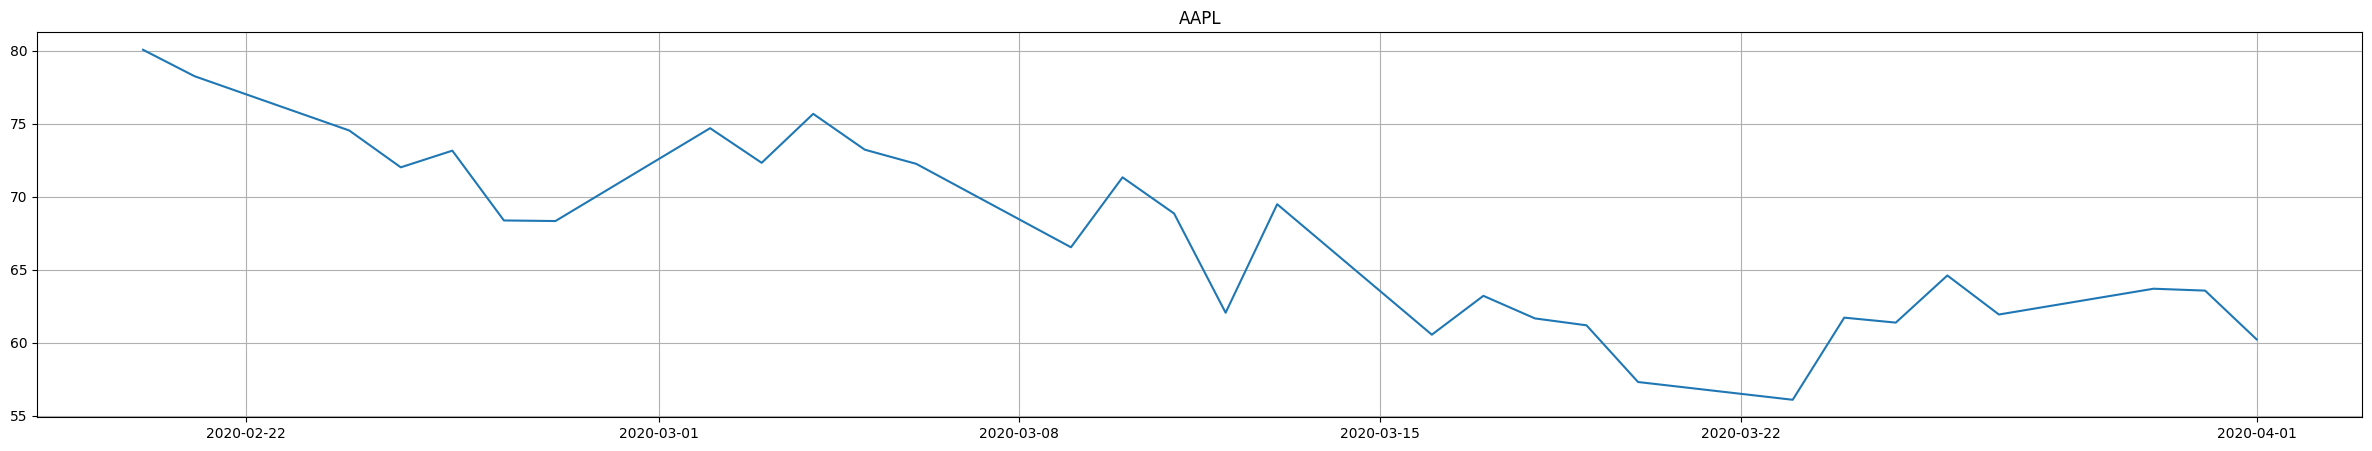

In [141]:
plot_price("AAPL", p["AAPL"])

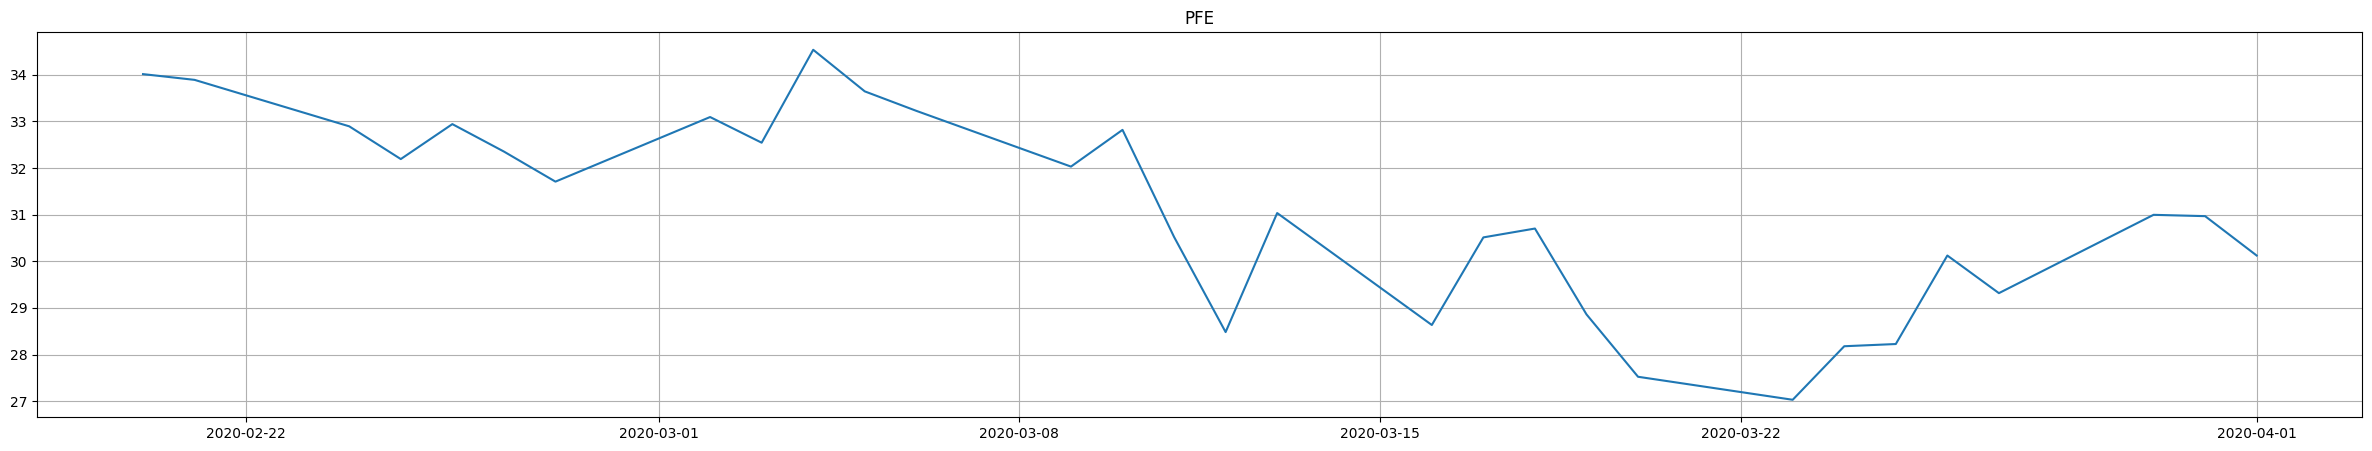

In [227]:
plot_price("PFE", p["PFE"])

In [218]:
prices_samples = [dsp.Example(question="ticker " + ticker, answer=make_sentence(ticker, p[ticker])) for ticker in tqdm.tqdm(tickers.keys(), position=0)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [00:00<00:00, 8549.78it/s]


In [143]:
prices_samples[:2]

[{'question': 'ticker CSCO',
  'answer': 'This is close prices for ticker CSCO for last 30 days:\n2020-02-20:46.85\n2020-02-21:46.3\n2020-02-24:44.0\n2020-02-25:42.74\n2020-02-26:42.16\n2020-02-27:40.04\n2020-02-28:39.93\n2020-03-02:41.17\n2020-03-03:40.04\n2020-03-04:41.39\n2020-03-05:39.57\n2020-03-06:39.68\n2020-03-09:37.96\n2020-03-10:40.08\n2020-03-11:37.05\n2020-03-12:33.2\n2020-03-13:37.64\n2020-03-16:33.71\n2020-03-17:35.5\n2020-03-18:37.12\n2020-03-19:37.71\n2020-03-20:35.6\n2020-03-23:34.6\n2020-03-24:38.6\n2020-03-25:37.67\n2020-03-26:40.58\n2020-03-27:38.82\n2020-03-30:40.32\n2020-03-31:39.31\n2020-04-01:38.33\n'},
 {'question': 'ticker UAL',
  'answer': 'This is close prices for ticker UAL for last 30 days:\n2020-02-20:79.91\n2020-02-21:78.01\n2020-02-24:75.47\n2020-02-25:70.57\n2020-02-26:66.53\n2020-02-27:64.94\n2020-02-28:61.59\n2020-03-02:61.26\n2020-03-03:58.29\n2020-03-04:59.47\n2020-03-05:51.59\n2020-03-06:52.1\n2020-03-09:46.78\n2020-03-10:52.56\n2020-03-11:49.34\n

0

In [126]:
from datetime import datetime

def convert_date_format(input_date):
    # Convert the input string to a datetime object
    date_object = datetime.strptime(input_date, '%b %d %Y')
    
    # Convert the datetime object to the desired format
    formatted_date = date_object.strftime('%Y-%m-%d')
    
    return formatted_date

news["Date"] = [convert_date_format(d) for d in news["Time"]]
news["News"] = news["Description"]

news.head()

,Headlines,Time,Description,Date,News
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,2020-07-18,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,2020-07-18,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,2020-07-18,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,2020-07-18,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,2020-07-17,A battle in the U.S. Congress over a new coron...


In [144]:
def upload_news_for_date(date, limit=None):
    res = news[news["Date"] <= date]["News"].values
    if limit is not None:
        res = res[-limit:]
    return res

In [145]:
actual_news = upload_news_for_date(DATE, 25 * 60)
len(actual_news)

1500

In [146]:
news_samples = [dsp.Example(question=it, answer=None) for it in actual_news]

In [189]:
with dsp.settings.context(vectorizer=dsp.SentenceTransformersVectorizer()):
    knn_func_news = dsp.knn(news_samples)

In [219]:
with dsp.settings.context(vectorizer=dsp.SentenceTransformersVectorizer()):
    knn_func_prices = dsp.knn(prices_samples)

In [190]:
turbo = dspy.OpenAI(model='gpt-3.5-turbo')  # can be replaced with llama or another model, see https://github.com/stanfordnlp/dspy/blob/7d578638d070818f319dc892bb662c435d1cc1bd/docs/using_local_models.md#hfmodel
# lm = dspy.HFClientTGI(model="meta-llama/Llama-2-7b-hf", port=8080, url="http://localhost")
# lm = dspy.HFModel(model = 'meta-llama/Llama-2-7b-hf')
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')

dspy.settings.configure(lm=turbo, rm=colbertv2_wiki17_abstracts)

In [340]:
GOLDEN_QUESTIONS = [
    "how oil prices can change for next month? give magor factors",
    "why is apple stock decreasing for last month?",
    "give me any information about outocumpu"
]

In [325]:
# secret = "today is " + DATE + " use list of current relevant news"

In [341]:
passages = 5
message = GOLDEN_QUESTIONS[2]
close_samples = [x["question"] for x in knn_func_news(dsp.Example(question=message, answer=None), passages)] \
+ [x["answer"] for x in knn_func_prices(dsp.Example(question=message, answer=None), passages)] \
+ dspy.Retrieve(k=passages)(message).passages

In [342]:
close_samples

['Dubai-based private equity firm Abraaj has hired U.S. investment bank Houlihan Lokey  to help it try to stem the fallout from a dispute with investors over its healthcare fund.',
 'Amazon.com Inc  and French retail group Casino Guichard Perrachon SA  are discussing "some kind of partnership" in Brazil involving Casino\'s local appliance and electronics unit Via Varejo SA , according to a Tuesday report on the website of newspaper O Globo.',
 'Russian authorities on Saturday arrested billionaire Ziyavudin Magomedov on charges of embezzling more than $35 million, in one of the highest-profile prosecutions of a Russian tycoon in years.',
 "China Huarong Asset Management Co  confirmed its chairman Lai Xiaomin, who is under investigation for alleged corruption, had stepped down, sparking an 11 percent tumble in shares of the nation's biggest bad debt manager on Friday.",
 "Japan's largest drugmaker Takeda Pharmaceutical  is considering a bid for London-listed rare disease specialist Shire

In [343]:
chain = dspy.ChainOfThought("context, question -> answer")

In [344]:
chain(context=close_samples, question=message).answer

'Outokumpu is a group of companies headquartered in Helsinki, Finland, producing stainless steel. It employs 10,785 employees in more than 30 countries. Outokumpu has a long history as a mining company and still mines chromium ore in Keminmaa for use as ferrochrome in stainless steel. [11]'